# Import Libraries

In [1]:
!pip install pydub

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf

In [4]:
import os
import pickle
import librosa

In [5]:
import pydub as pyd
import IPython.display as ipd

# Import Models

## Speech Emotion Recognition Model

In [7]:
json_file = open('/models/audio_ser_model/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

In [8]:
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
loaded_model.load_weights("/models/audio_ser_model/best_model_weights.h5")

In [9]:
with open('/models/audio_ser_model/scaler.pickle', 'rb') as f:
    scaler = pickle.load(f)

with open('/models/audio_ser_model/encoder.pickle', 'rb') as f:
    encoder = pickle.load(f)

In [ ]:
# set input path to any audio file
input_path = "/audio_data/input_data_dir/OAF_back_angry.wav"

# 1. Audio file Analysis

In [ ]:
# Load audio data
audio_data, audio_sr = librosa.load(input_path)

# Audio
ipd.Audio(audio_data, rate=audio_sr)

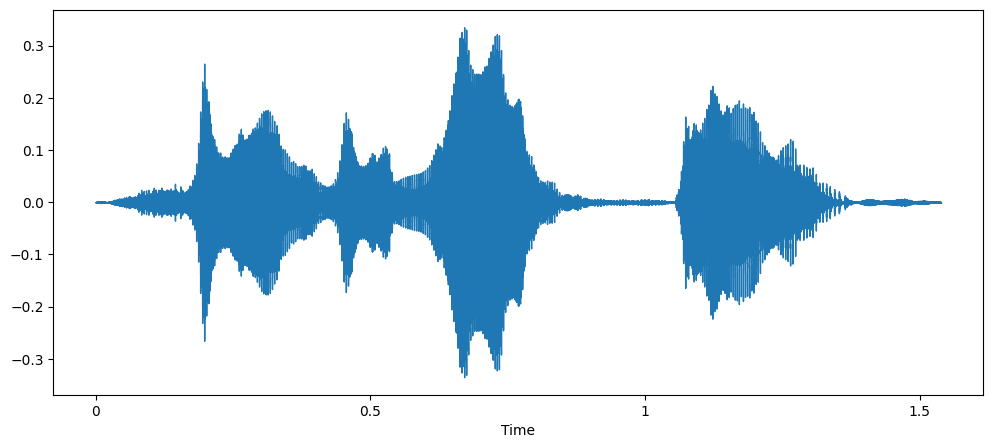

In [ ]:
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=audio_data, sr=audio_sr);

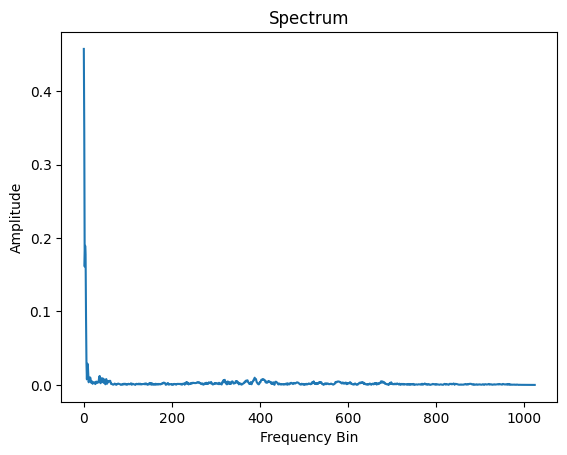

In [ ]:
n_fft = 2048
D = np.abs(librosa.stft(audio_data[:n_fft], n_fft=n_fft, hop_length=n_fft+1))
plt.title('Spectrum');
plt.xlabel('Frequency Bin');
plt.ylabel('Amplitude');
plt.plot(D);

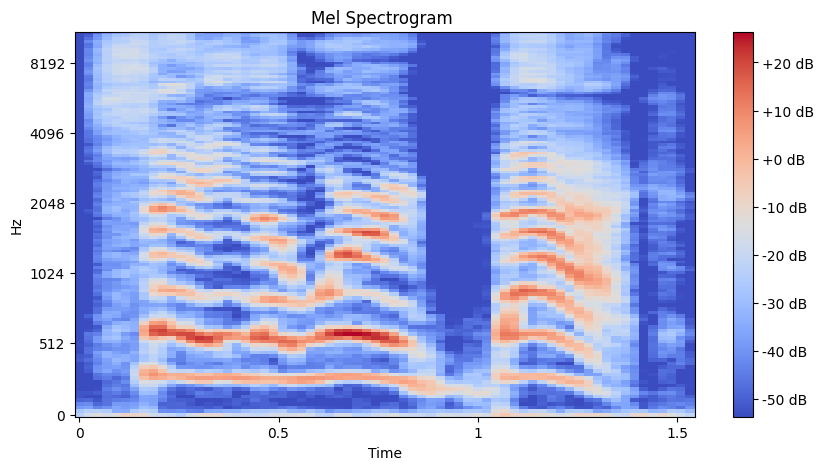

In [ ]:
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=audio_sr, n_mels=128,fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=audio_sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB');

# 2. Speech Emotion Recognition Module

In [10]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    mfcc_result = librosa.feature.mfcc(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(mfcc_result.T) if not flatten else np.ravel(mfcc_result.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((
      result,
      zcr(data,frame_length,hop_length),
      rmse(data,frame_length,hop_length),
      mfcc(data,sr,frame_length,hop_length)
    ))

    return result

In [11]:
def get_predict_feat(path, expected_shape=(1, 2376)):
    d, s_rate = librosa.load(path, duration=2.5, offset=0.6)
    res = extract_features(d)

    # Ensure res is reshaped or padded to match the expected shape
    if res.shape != expected_shape:
        flat_size = np.prod(expected_shape)
        if res.size < flat_size:
            # Pad if the size is smaller than expected
            pad_width = (0, flat_size - res.size)
            res = np.pad(res, pad_width=pad_width, mode='constant')
        else:
            # Resize if the size is larger than expected
            res = np.resize(res, expected_shape)

    i_result = scaler.transform(res.reshape(1, -1))
    final_result = np.expand_dims(i_result, axis=2)

    return final_result

In [12]:
def prediction(path1):
    res = get_predict_feat(path1)
    predictions = loaded_model.predict(res)

    # Get the label names or define them if available
    label_names = list(encoder.categories_[0])

    # Get the index of the label with the highest confidence score
    predicted_label_index = np.argmax(predictions)

    # List to store confidence scores
    confidence_scores = []

    # Display predicted emotion and confidence for each label
    print(f"Predicted Emotion: {label_names[predicted_label_index]}")
    for label_index, label_name in enumerate(label_names):
        confidence_score = predictions[0][label_index]
        confidence_score = 0 if confidence_score < 0.001 else confidence_score

        print(f"{label_name}: {confidence_score}")
        confidence_scores.append({'label': label_name, 'confidence': confidence_score})

    print("\n")

    sorted_confidence_scores = sorted(confidence_scores, key=lambda x: x['confidence'], reverse=True)

    return sorted_confidence_scores

In [ ]:
prediction(input_path)